In [1]:
# Python
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pylab as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import models
%matplotlib inline 

sunshine_data = pd.read_csv('Dataset/sunshine_data.csv')


/mnt/DATA1/wuliubin/miniconda3/envs/metro/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
train_data = sunshine_data[['Data', 'Time', 'Radiation']]

In [3]:
# 日期和时间两列合并
train_data = train_data.assign(Datetime=pd.to_datetime(train_data['Data'] + ' ' + train_data['Time']))
train_data = train_data[['Datetime', 'Radiation']].rename(columns={'Datetime': 'ds', 'Radiation': 'y'})

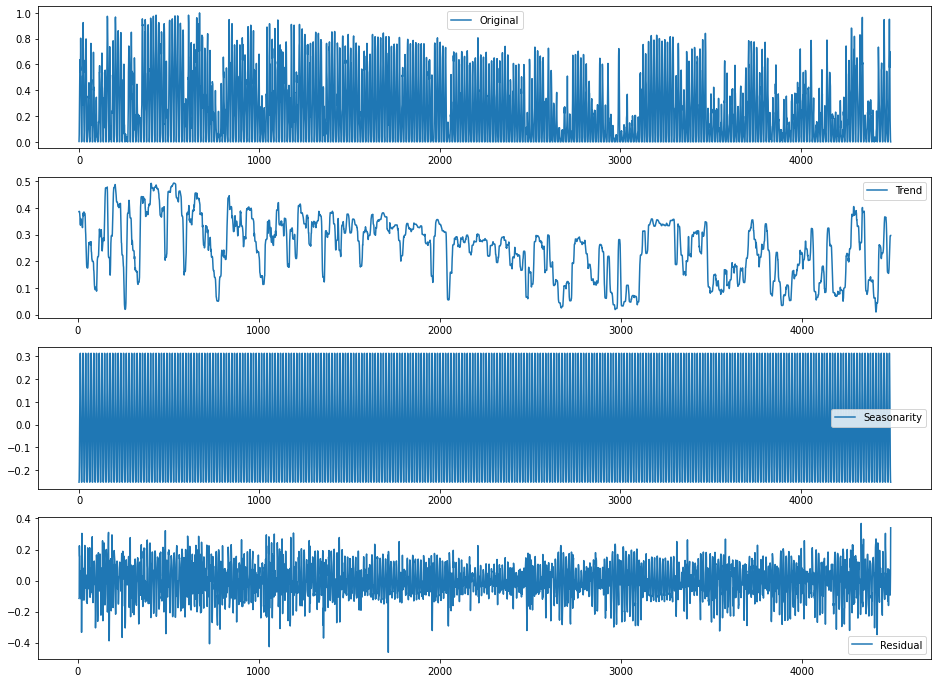

In [4]:
# 对数据进行分解
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries, period=15)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()
    
    return trend, seasonal, residual

trend, seasonal, residual = decomposing(train_data['y'])
train_data[['trend', 'seasonal', 'residual']] = pd.DataFrame({'trend': trend, 'seasonal': seasonal, 'residual': residual})
train_data.to_csv("Results/data.csv", index=False, sep=',')

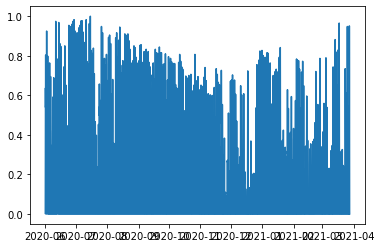

In [14]:
plt.plot(train_data['ds'], train_data['y'])

/mnt/DATA1/wuliubin/miniconda3/envs/metro/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 720x360 with 0 Axes>

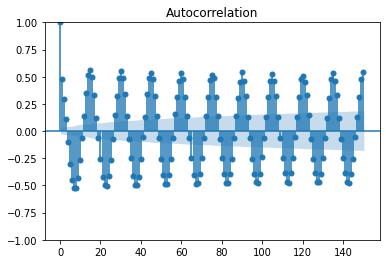

<Figure size 720x360 with 0 Axes>

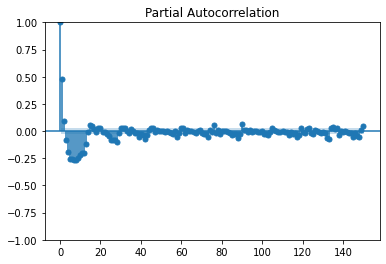

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Differencing
data_df = train_data['y'].diff(1).dropna()
# plot the ACF and PACF
plt.figure(figsize=(10, 5))
plot_acf(data_df, lags=150, alpha=0.05)
plt.figure(figsize=(10, 5))
plot_pacf(data_df, lags=150, alpha=0.05)
plt.show()

In [9]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train_data['y'], order=(8,0,0), seasonal_order=(2, 1, 1, 15),\
                 enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.46989D-01    |proj g|=  2.73423D+00


 This problem is unconstrained.



At iterate    5    f= -9.76932D-01    |proj g|=  2.70199D-01

At iterate   10    f= -9.90435D-01    |proj g|=  2.69268D-01

At iterate   15    f= -1.00070D+00    |proj g|=  2.16162D-01

At iterate   20    f= -1.04241D+00    |proj g|=  3.20130D+00

At iterate   25    f= -1.07402D+00    |proj g|=  7.03132D-01

At iterate   30    f= -1.07761D+00    |proj g|=  1.63119D-01

At iterate   35    f= -1.07808D+00    |proj g|=  4.68251D-02

At iterate   40    f= -1.07831D+00    |proj g|=  5.84140D-03

At iterate   45    f= -1.07836D+00    |proj g|=  4.02756D-03

At iterate   50    f= -1.07841D+00    |proj g|=  3.15173D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/mnt/DATA1/wuliubin/miniconda3/envs/metro/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 4500
Model:             SARIMAX(8, 0, 0)x(2, 1, [1], 15)   Log Likelihood                4852.837
Date:                              Mon, 10 Oct 2022   AIC                          -9681.673
Time:                                      18:38:22   BIC                          -9604.874
Sample:                                           0   HQIC                         -9654.596
                                             - 4500                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8864      0.009    100.907      0.000       0.869       0.904
ar.L2         -0.05

<AxesSubplot:>

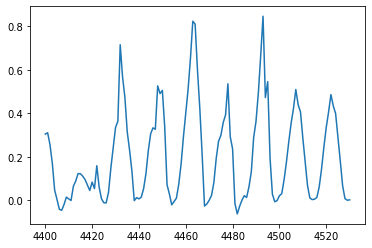

In [15]:
results.predict(4400, 4530).plot()